# Comparison of velocities between EM and VI model

## Library imports

In [1]:
import os
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.metrics import accuracy_score
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.colors import to_hex

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics

from _calculation import get_gams

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR, PROJECT_DIR

Global seed set to 0


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'comparison', exist_ok=True)

## Function definitions

In [5]:
def fit_scvelo(adata):
    scv.tl.recover_dynamics(
        adata, fit_scaling=False, var_names=adata.var_names, n_jobs=8
    )
    adata.var["fit_scaling"] = 1.0
    scv.tl.velocity(adata, mode="dynamical", min_likelihood=-np.inf, min_r2=None)

In [6]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

In [7]:
def compute_confidence(adata, vkey="velocity"):
    velo = adata.layers[vkey]
    scv.tl.velocity_graph(adata, vkey=vkey, n_jobs=8)
    scv.tl.velocity_confidence(adata, vkey=vkey)

    g_df = pd.DataFrame()
    g_df["Velocity confidence"] = adata.obs[f"{vkey}_confidence"].to_numpy().ravel()

    return g_df

In [8]:
def add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)
    
    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot(
        [left, left, right, right],
        [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs
    )

    
    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha='center',
        va='bottom',
        c='k'
    )

In [9]:
def get_classification_scores(velo_sign_true, velo_sign_pred, score_fun, **kwargs):
    n_vars = velo_sign_true.shape[1]
    em_score = [
        score_fun(velo_sign_true[:, var_id], velo_sign_pred["EM"][:, var_id], **kwargs)
        for var_id in range(n_vars)
    ]

    vi_score = [
        score_fun(velo_sign_true[:, var_id], velo_sign_pred["VI"][:, var_id], **kwargs)
        for var_id in range(n_vars)
    ]
    
    return em_score, vi_score

In [10]:
def get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [11]:
def plot_classification_score(em_score, vi_score, baseline_performance, score_name, **kwargs):
    n_vars = len(em_score)
    df = pd.DataFrame(
        {
            score_name: vi_score + em_score + baseline_performance,
            "Model": ["VI"] * n_vars + ["EM"] * n_vars + ["Random"] * n_vars
        }
    )

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))

        sns.boxplot(data=df, x="Model", y=score_name, palette="colorblind", ax=ax)

## Data loading

In [12]:
adata = sc.read(DATA_DIR / "fucci" / "adata.h5ad")
adata.X = adata.layers["spliced"].copy()

del adata.layers["ambiguous"]
del adata.layers["matrix"]
del adata.layers["spanning"]

adata.obs.drop(
    ["Well_Plate", "plate", "MeanGreen530", "MeanRed585", "initial_size_unspliced", "initial_size_spliced", "initial_size"],
    axis=1,
    inplace=True
)

adata.var_names = adata.var["name"].values
adata.var.drop(adata.var.columns, axis=1, inplace=True)

adata.obs["pseudo_clusters"] = pd.cut(adata.obs["fucci_time"], bins=5, labels=False).astype(str).astype("category")

adata.obs["pseudo_clusters_equal_size"] = pd.qcut(adata.obs["fucci_time"], q=5, labels=False)
adata.obs["pseudo_clusters_equal_size_num"] = adata.obs["pseudo_clusters_equal_size"].astype(float)

adata.obs["cell_cycle_rad"] = adata.obs["fucci_time"] / adata.obs["fucci_time"].max() * 2 * np.pi

adata

AnnData object with n_obs × n_vars = 1146 × 19997
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad'
    layers: 'spliced', 'unspliced'

## Data preprocessing

In [13]:
scv.pp.filter_and_normalize(adata, min_counts=10, n_top_genes=2000)

Filtered out 4748 genes that are detected 10 counts (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [14]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


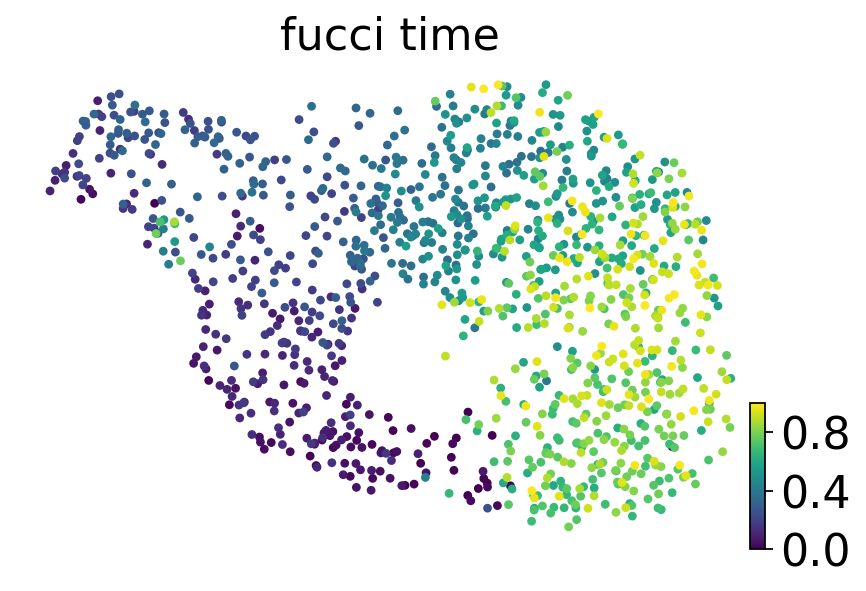

In [15]:
sc.tl.umap(adata)
scv.pl.scatter(adata, basis='umap', color='fucci_time', cmap='viridis')

In [16]:
adata = preprocess_data(adata)

bdata = adata.copy()

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Model fitting

### EM model

In [17]:
fit_scvelo(adata)

recovering dynamics (using 8/14 cores)


  0%|          | 0/395 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:00:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


### veloVI

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 465/500:  93%|█████████▎| 465/500 [01:36<00:07,  4.80it/s, loss=-566, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -589.328. Signaling Trainer to stop.


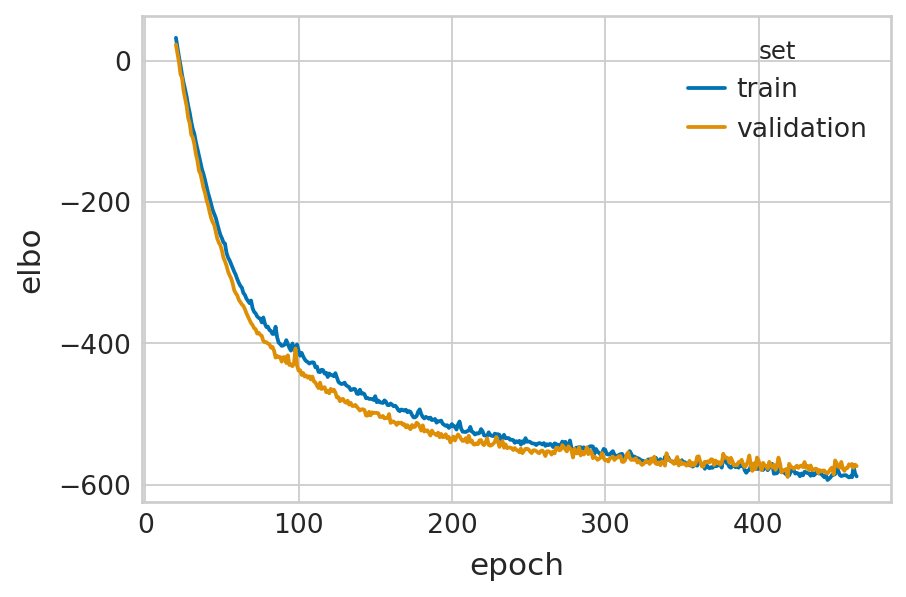

In [18]:
velovi_vae = fit_velovi(bdata)

### Empricial velocity

In [19]:
cell_cycle_pos = np.sort(adata.obs["cell_cycle_rad"].unique())[:-1]

aggr_counts = []
for pos in tqdm(cell_cycle_pos):
    if pos == 0:
        mask = ((adata.obs["cell_cycle_rad"] == 0) | (adata.obs["cell_cycle_rad"] == 2 * np.pi)).values
    else:
        mask = (adata.obs["cell_cycle_rad"] == pos).values
    
    aggr_counts.append(np.median(adata.layers["Ms"][mask, :], axis=0))

aggr_counts = np.vstack(aggr_counts)

100%|██████████| 996/996 [00:00<00:00, 5025.74it/s]


In [20]:
reorder_mask = np.arange(1, adata.obs["cell_cycle_rad"].nunique() - 1).tolist() + [0]

cc_pos_diff = cell_cycle_pos.copy()
cc_pos_diff = (cc_pos_diff[reorder_mask] - cc_pos_diff) % (2 * np.pi)

empirical_velo = (aggr_counts[reorder_mask, :] - aggr_counts) / cc_pos_diff.reshape(-1, 1)

empirical_velo_sign = np.sign(empirical_velo)

### Velocity processing

In [21]:
aggr_velo = {"EM": [], "VI": []}

for pos in tqdm(cell_cycle_pos):
    if pos == 0:
        mask = ((adata.obs["cell_cycle_rad"] == 0) | (adata.obs["cell_cycle_rad"] == 2 * np.pi)).values
    else:
        mask = (adata.obs["cell_cycle_rad"] == pos).values

    aggr_velo["EM"].append(np.median(adata.layers["velocity"][mask, :], axis=0))
    aggr_velo["VI"].append(np.median(bdata.layers["velocities_velovi"][mask, :], axis=0))

aggr_velo["EM"] = np.vstack(aggr_velo["EM"])
aggr_velo["VI"] = np.vstack(aggr_velo["VI"])

100%|██████████| 996/996 [00:00<00:00, 4060.77it/s]


In [22]:
aggr_velo_sign = {}
aggr_velo_sign["EM"] = np.sign(aggr_velo["EM"])
aggr_velo_sign["VI"] = np.sign(aggr_velo["VI"])

## Velocity consistency

In [23]:
dfs = []

g_df = compute_confidence(adata)
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "EM model"
dfs.append(g_df)

g_df = compute_confidence(bdata, vkey="velocities_velovi")
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "veloVI"
dfs.append(g_df)

conf_df = pd.concat(dfs, axis=0)

computing velocity graph (using 8/14 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity graph (using 8/14 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocities_velovi_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocities_velovi_length' (adata.obs)
--> added 'velocities_velovi_confidence' (adata.obs)
--> added 'velocities_velovi_confidence_transition' (adata.obs)


/vol/storage/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/vol/storage/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


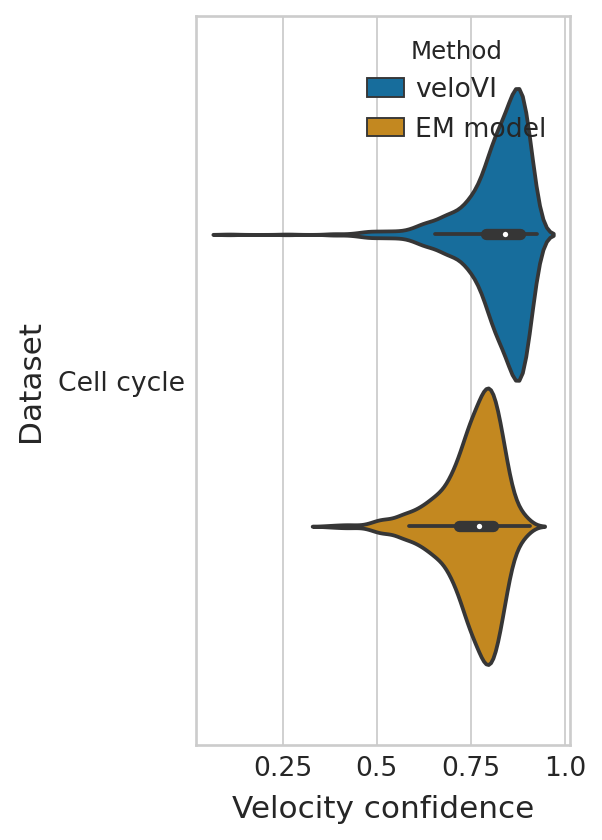

In [24]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 6))
    sns.violinplot(
        data=conf_df,
        ax=ax,
        orient="h",
        y="Dataset",
        x="Velocity confidence",
        hue="Method",
        hue_order=["veloVI", "EM model"],
        palette=sns.color_palette(['#0173B2', '#DE8F05']),
    );
    
    ax.set_xticks([0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels([0.25, 0.5, 0.75, 1.0]);

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'fucci_velocity_confidence.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

## GAM fitting

In [25]:
gams = {}

gams["EM"] = get_gams(adata=adata, layer="velocity", time="cell_cycle_rad", n_jobs=8)
gams["VI"] = get_gams(adata=bdata, layer="velocities_velovi", time="cell_cycle_rad", n_jobs=8)

100%|██████████| 395/395 [00:01<00:00, 359.66it/s]


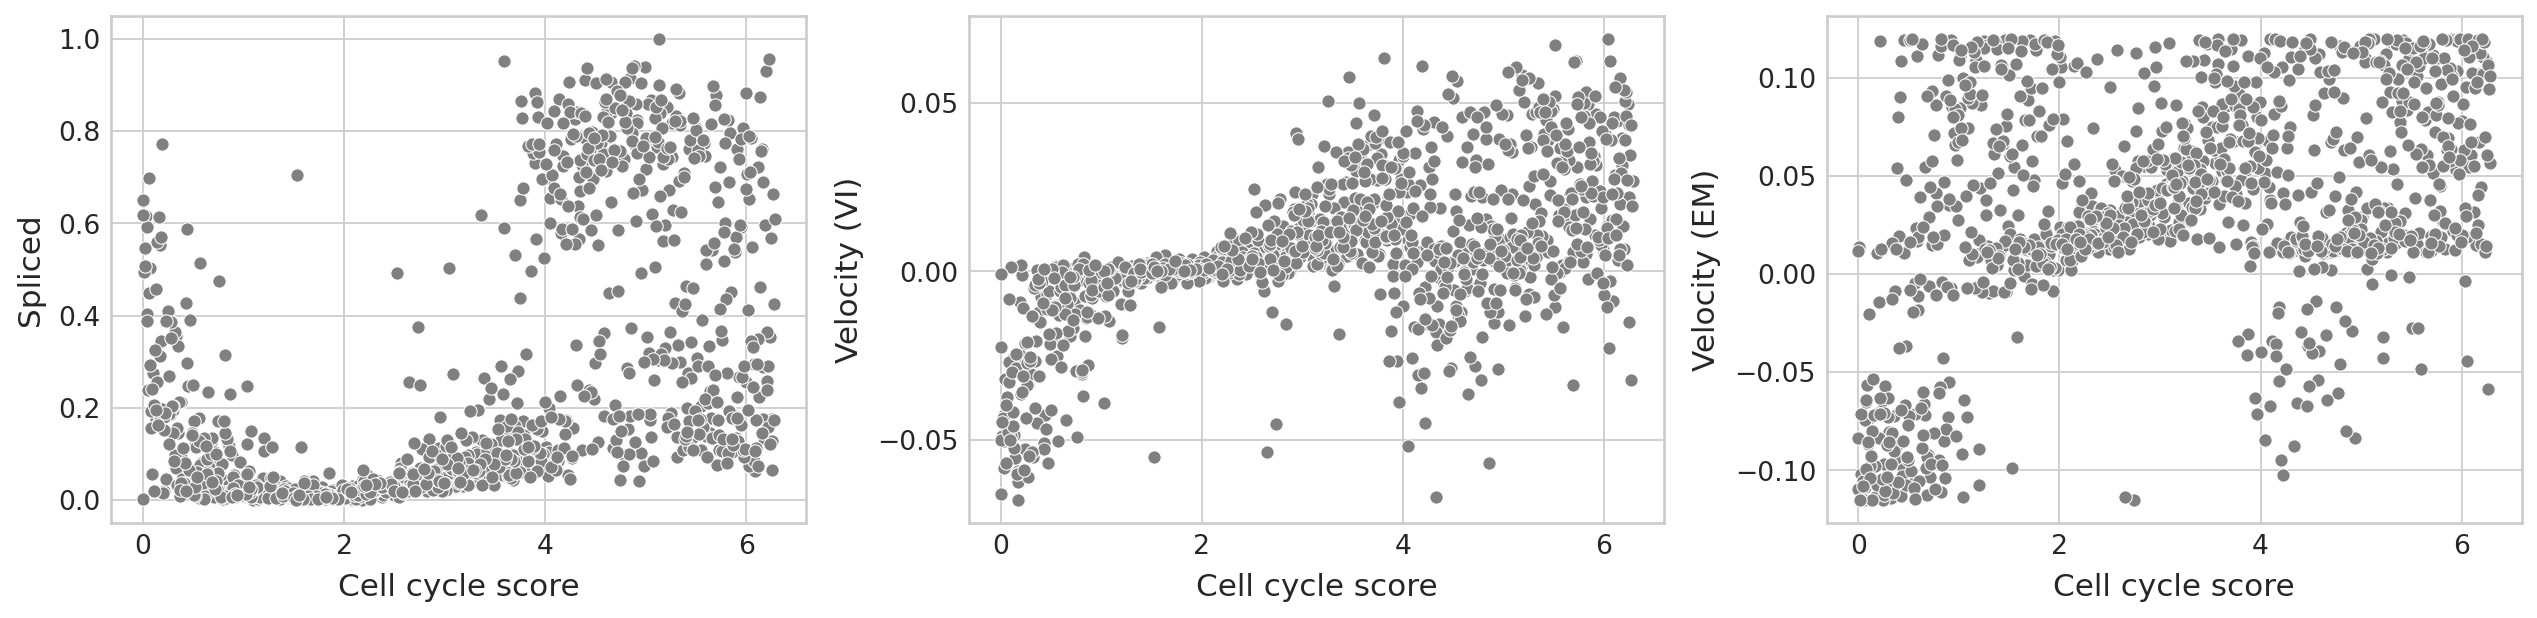

In [26]:
var_id = 186

df = pd.DataFrame(
    {
        "Velocity (EM)": adata.layers["velocity"][:, var_id],
        "Velocity (VI)": bdata.layers["velocities_velovi"][:, var_id],
        "Cell cycle score": adata.obs["cell_cycle_rad"].values,
        "Unspliced": adata.layers["Mu"][:, var_id],
        "Spliced": adata.layers["Ms"][:, var_id],
    }
)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(16, 4), ncols=3)

    sns.scatterplot(data=df, x="Cell cycle score", y="Spliced", color="grey", ax=ax[0])
    sns.scatterplot(data=df, x="Cell cycle score", y="Velocity (VI)", color="grey", ax=ax[1])
    sns.scatterplot(data=df, x="Cell cycle score", y="Velocity (EM)", color="grey", ax=ax[2])
    
    plt.tight_layout()
    
if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'fucci_velo_vs_time.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [27]:
cell_cycle_score = adata.obs["cell_cycle_rad"].values
cell_cycle_score = np.vstack([cell_cycle_score - 2 * np.pi, cell_cycle_score, cell_cycle_score + 2 * np.pi]).T

adata.var["gam_r2_scores"] = [
    gam._estimate_r2(X=cell_cycle_score, y=adata.layers["velocity"][:, var_id])["McFadden"]
    for var_id, gam in enumerate(gams["EM"].values())
]

bdata.var["gam_r2_scores"] = [
    gam._estimate_r2(X=cell_cycle_score, y=bdata.layers["velocities_velovi"][:, var_id])["McFadden"]
    for var_id, gam in enumerate(gams["VI"].values())
]

/vol/storage/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/vol/storage/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If yo

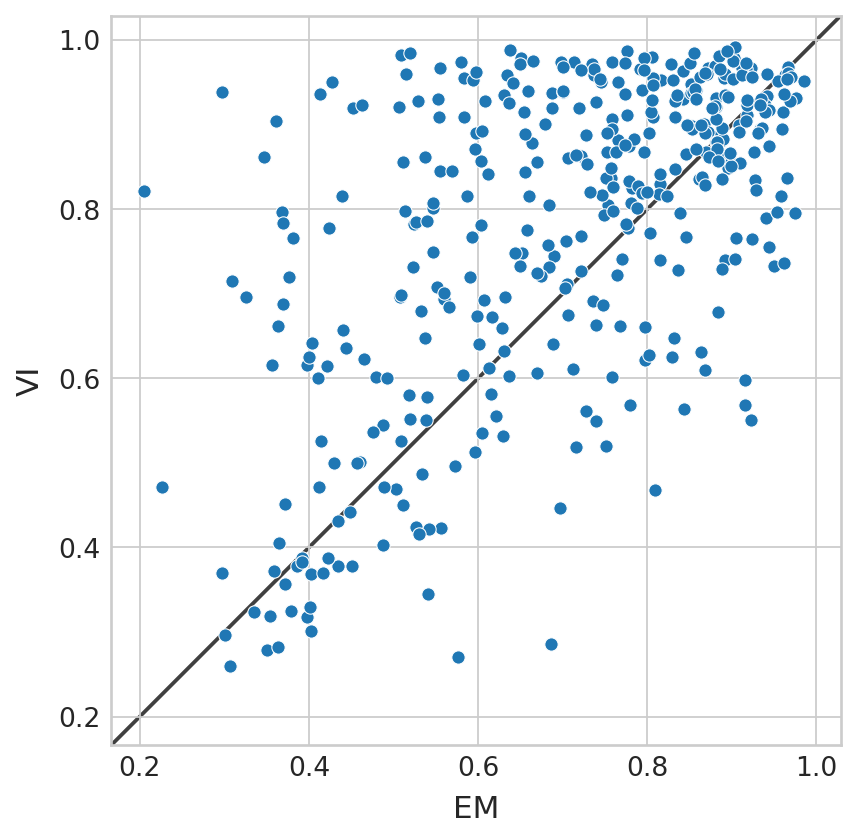

In [28]:
df = pd.DataFrame(
    {
        "EM": adata.var["gam_r2_scores"].values,
        "VI": bdata.var["gam_r2_scores"].values,
    }
)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.scatterplot(data=df, x="EM", y="VI", ax=ax)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims);

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'fucci_r2.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [29]:
(bdata.var["gam_r2_scores"].values > adata.var["gam_r2_scores"].values).mean()

0.6531645569620254

## Estimated velocity vs. empirical velocity

In [30]:
np.random.seed(0)
random_velo_sign = np.random.choice([-1, 0, 1], size=(len(empirical_velo_sign), adata.n_vars))
baseline_performance = [
    accuracy_score(empirical_velo_sign[:, var_id], random_velo_sign[:, var_id])
    for var_id in range(adata.n_vars)
]

In [31]:
em_score, vi_score = get_classification_scores(
    velo_sign_true=empirical_velo_sign,
    velo_sign_pred=aggr_velo_sign,
    score_fun=accuracy_score,
)

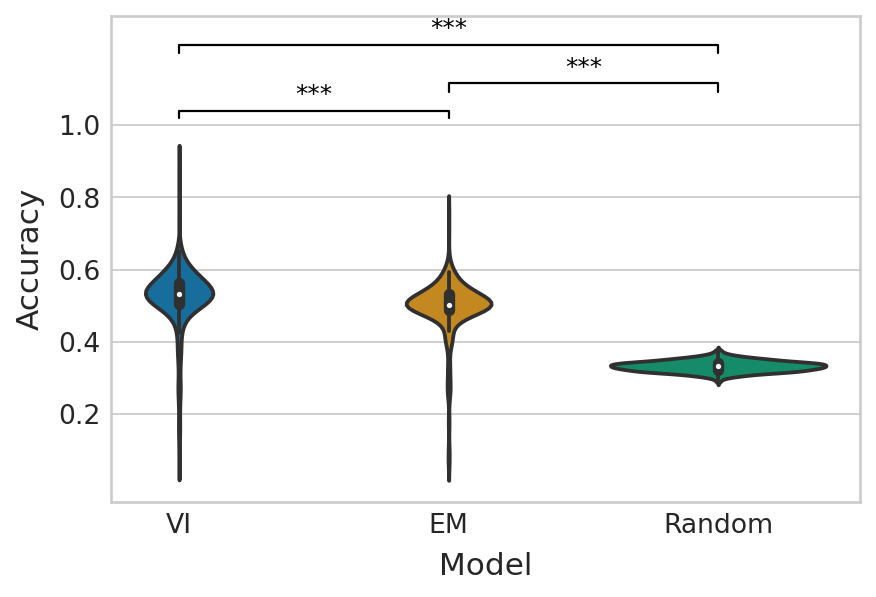

In [32]:
df = pd.DataFrame(
    {
        "Accuracy": vi_score + em_score + baseline_performance,
        "Model": ["VI"] * adata.n_vars + ["EM"] * adata.n_vars + ["Random"] * adata.n_vars
    }
)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.violinplot(data=df, x="Model", y="Accuracy", palette="colorblind", ax=ax)

    ttest_res = ttest_ind(vi_score, em_score, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )

    ttest_res = ttest_ind(em_score, baseline_performance, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=1, right=2, significance=significance, lw=1, c="k", level=1, bracket_level=0.95
    )

    ttest_res = ttest_ind(em_score, baseline_performance, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.9
    )

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])
    
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1.0]);

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'fucci_velocity_sign_accuracy.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )